In [2]:
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from smp import config
import os

In [3]:
from smp.dataset import SegmentationDataset, Split
from smp.transform import get_train_transform, get_valid_transform
from torch.utils.data import DataLoader

transform = get_train_transform(config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDTH)
transform_valid = get_valid_transform(config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDTH)

train_dataset = SegmentationDataset(config.DATASET_PATH, Split.TRAIN, valid_size=config.VALID_SIZE, transform=transform)
valid_dataset = SegmentationDataset(config.DATASET_PATH, Split.VALID, valid_size=config.VALID_SIZE, transform=transform_valid)
test_dataset = SegmentationDataset(config.DATASET_PATH, Split.TEST, valid_size=config.VALID_SIZE, transform=transform_valid)

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

train_dataloader = DataLoader(
    train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS
)
valid_dataloader = DataLoader(
    valid_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS
)
test_dataloader = DataLoader(
    test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS
)

Resolving data files:   0%|          | 0/1793 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/183 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1793 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/183 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1793 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/183 [00:00<?, ?it/s]

Train size: 896
Valid size: 128
Test size: 104


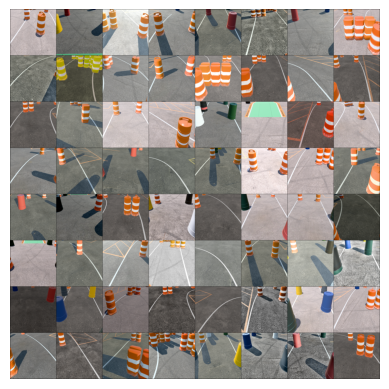

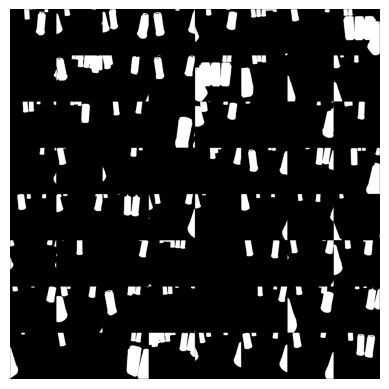

In [15]:
from torchvision import utils

# Helper function for inline image display
def matplotlib_imshow(img):
    plt.imshow(img.permute(1, 2, 0))

dataiter = iter(train_dataloader)
item = next(dataiter)
images = item["image"]
labels = item["mask"]

# Create a grid from the images and show them
img_grid = utils.make_grid(images)
mask_grid = utils.make_grid(labels)
matplotlib_imshow(img_grid)
plt.axis("off")
plt.show()
matplotlib_imshow(mask_grid)
plt.axis("off")
plt.show()

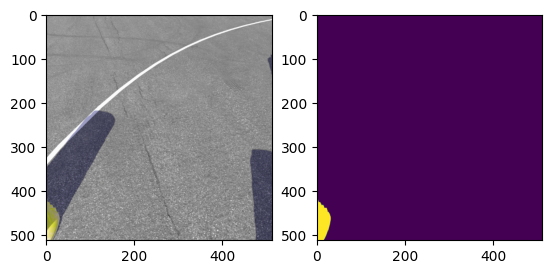

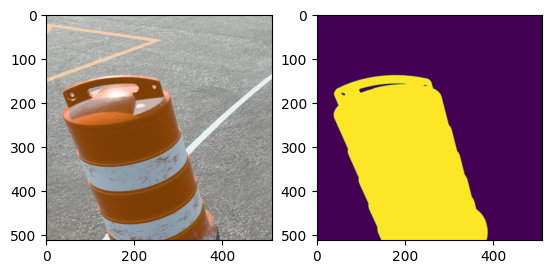

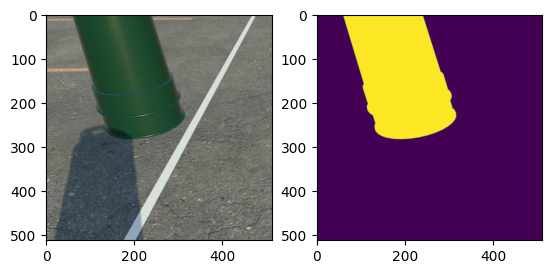

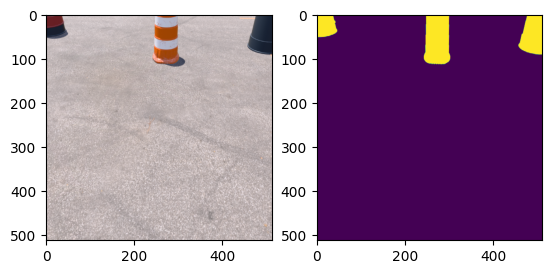

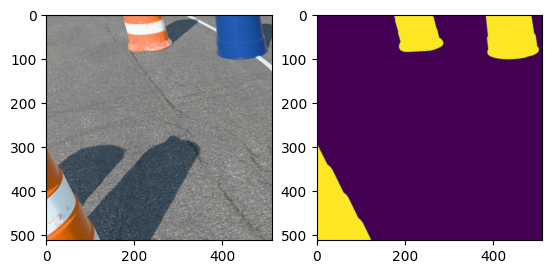

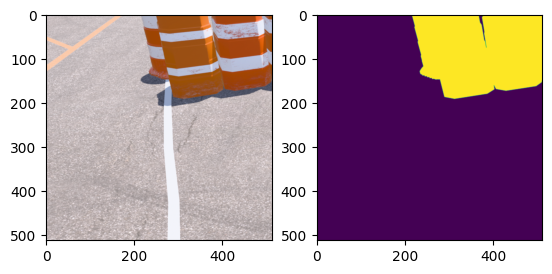

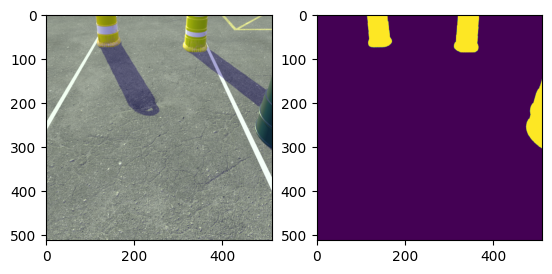

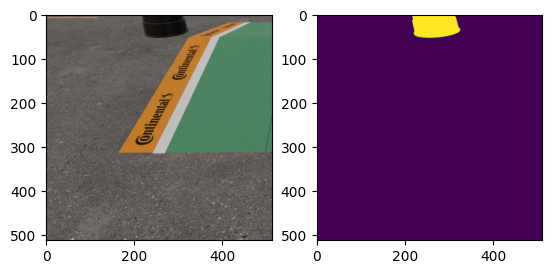

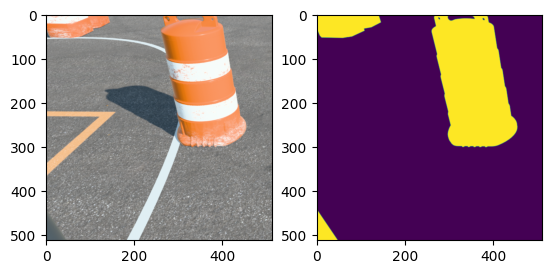

In [3]:
# lets look at some samples

def show_sample(dataset, index):
    sample = dataset[index]
    plt.subplot(1, 2, 1)
    # for visualization we have to transpose back to HWC
    plt.imshow(sample["image"].transpose(1, 2, 0))
    plt.subplot(1, 2, 2)
    # for visualization we have to remove 3rd dimension of mask
    plt.imshow(sample["mask"].transpose(1, 2, 0))
    plt.show()

# show some samples
for i in range(3):
    show_sample(train_dataset, i)
    show_sample(valid_dataset, i)
    show_sample(test_dataset, i)

In [4]:
from smp.model import SegmentationModel

if config.DEVICE == "cuda":
    # Reduce VRAM usage by reducing fragmentation
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
    torch.set_float32_matmul_precision("high")

T_MAX = config.NUM_EPOCHS * len(train_dataloader)

model = SegmentationModel("FPN", "resnet34", T_max=T_MAX, in_channels=3, out_classes=1)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [4]:

trainer = pl.Trainer(max_epochs=config.NUM_EPOCHS, log_every_n_steps=1)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 23.2 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)
175       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.59 GiB. GPU 0 has a total capacity of 79.15 GiB of which 1.17 GiB is free. Process 1303862 has 1006.00 MiB memory in use. Process 934047 has 5.83 GiB memory in use. Process 243512 has 25.70 GiB memory in use. Including non-PyTorch memory, this process has 45.44 GiB memory in use. Of the allocated memory 44.90 GiB is allocated by PyTorch, and 56.51 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
%load_ext tensorboard

%tensorboard --logdir lightning_logs

In [ ]:
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [7]:
# get original model from lightning PetModel
smp_model = model.model
# if push_to_hub=True, model will be saved to repository with this name
commit_info = model.model.save_pretrained(
    save_directory="model/igvs-segmentation",
    push_to_hub=False,  # optional, push model to HF Hub
    dataset=config.DATASET_NAME,  # optional, save dataset name in model card
)

In [5]:
# load the mode

model.load_pretrained("model/igvs-segmentation")

Loading weights from local directory


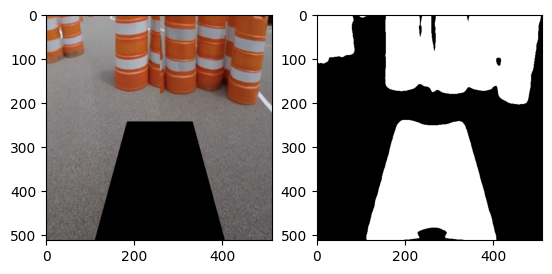

In [9]:
# load "./test_1.png" and apply transform

from PIL import Image
import numpy as np
import torchvision
from torchvision.transforms import v2

def load_image(image_path):
    image = torchvision.io.read_image(image_path)
    if image.shape[0] == 4:
        image = image[:3, :, :]
    # resize to (3, 512, 512)
    trans = v2.Compose([
        v2.Resize((config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDTH)),
    ])
    image = trans(image)
    # add batch dimension
    image = image.unsqueeze(0)
    return image


def predict(model, image):
    with torch.no_grad():
        model.eval()
        image = image
        output = model(image)
        output = torch.sigmoid(output)
        output = (output > 0.5).float()

        return output.cpu().numpy()[0]  # remove batch dimension and move to CPU
    
def show_prediction(image, mask):
    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(mask[0], cmap="gray")
    plt.show()

# load image
image_path = "./1-00004.png"
image = load_image(image_path)
# predict
mask = predict(model, image)
# show prediction
show_prediction(image[0].cpu(), mask)



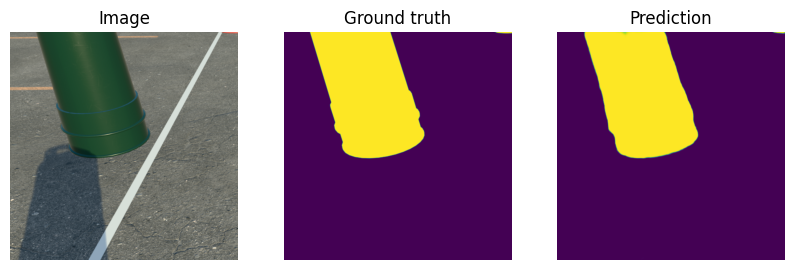

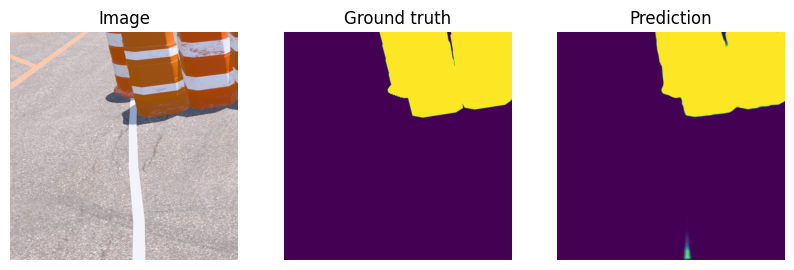

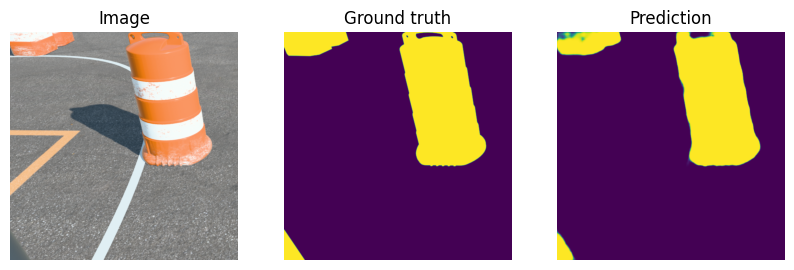

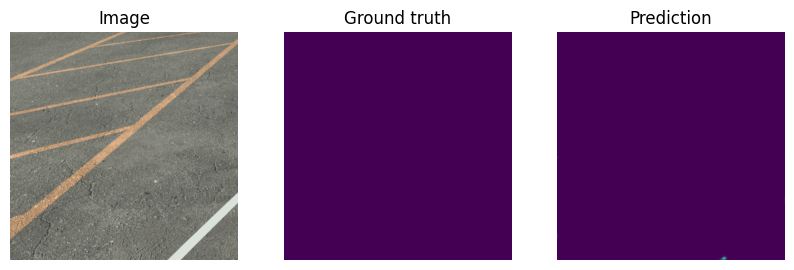

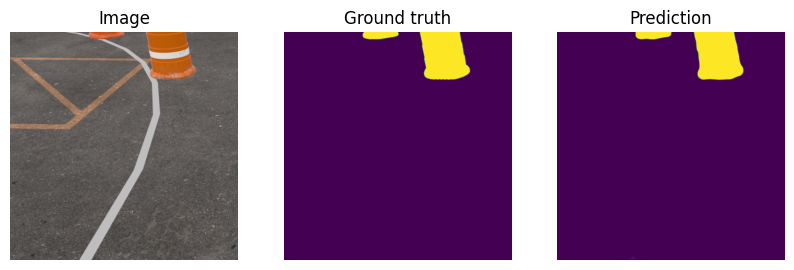

In [8]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(
    zip(batch["image"], batch["mask"], pr_masks)
):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break